# Funciones auxiliares

Definimos una serie de funciones, que nos ayudarán con el tratado de las imágenes

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def norm(im):
    """Normaliza una imagen de números reales a [0,1]"""

    return cv2.normalize(im, None, 0.0, 1.0, cv2.NORM_MINMAX)

def read_im(filename, color_flag = 1):
    """Devuelve una imagen de números reales adecuadamente leída en grises o en color.
        - filename: ruta de la imagen.
        - color_flag: indica si es en color (1) o en grises (0)."""

    try:
        im = cv2.imread(filename, color_flag)
        if len(im.shape) == 3:
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    except:
        print("Error: no se ha podido cargar la imagen " + filename)
        quit()

    return im.astype(np.double)

def print_im(im, title = "", show = True, tam = (10, 10)):
    """Muestra una imagen cualquiera normalizada.
        - im: imagen a mostrar.
        - show: indica si queremos mostrar la imagen inmediatamente.
        - tam = (width, height): tamaño del plot."""

    show_title = len(title) > 0

    if show:
        fig = plt.figure(figsize = tam)

    im = norm(im)  # Normalizamos a [0,1]
    plt.imshow(im, interpolation = None, cmap = 'gray')
    plt.xticks([]), plt.yticks([])

    if show:
        if show_title:
            plt.title(title)
        plt.show() 

def print_multiple_im(vim, titles = "", ncols = 2, tam = (10, 10)):
    """Muestra una sucesión de imágenes en la misma ventana, eventualmente con sus títulos.
        - vim: sucesión de imágenes a mostrar.
        - titles: o bien vacío o bien una sucesión de títulos del mismo tamaño que vim.
        - ncols: número de columnas del multiplot.
        - tam = (width, height): tamaño del multiplot."""

    show_title = len(titles) > 0

    nrows = len(vim) // ncols + (0 if len(vim) % ncols == 0 else 1)
    plt.figure(figsize = tam)

    for i in range(len(vim)):
        plt.subplot(nrows, ncols, i + 1)
        if show_title:
            plt.title(titles[i])
        print_im(vim[i], title = "", show = False)

    plt.show()

# Brain Tumor Detector

IMPORTANTE: La base de datos que usamos se encuentra en [kaggle](https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri), y la hemos subido convenientemente a nuestro drive colaborativo para poder cargarla.

Con la siguiente función vamos a leer las imágenes de las carpetas donde tenemos los datos y les haremos un redimensionado a (224,224) por temas de uso de RAM en googleColab

In [ ]:
import cv2 
import os

from google.colab import drive
drive.mount('/content/drive')

def load_images_from_folder(folder, len):
    images = []
    i=1
    for filename in os.listdir(folder):
        img = read_im(os.path.join(folder,filename),1)
        img = cv2.resize(img,(224,224))
        if img is not None:
            images.append(img)
        if i == len:
          break
        i += 1
    return images

PATH="/content/drive/MyDrive/Colab Notebooks/Proyecto VC/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


cargamos los datos

In [ ]:
data=load_images_from_folder(PATH + "images/Training/no_tumor",395)
data= data + load_images_from_folder(PATH + "images/Testing/no_tumor",105)
data= data + load_images_from_folder(PATH + "images/Testing/glioma_tumor",100)
data= data + load_images_from_folder(PATH + "images/Training/glioma_tumor",400)
data= data + load_images_from_folder(PATH + "images/Testing/meningioma_tumor",105)
data= data + load_images_from_folder(PATH + "images/Training/meningioma_tumor",395)
data= data + load_images_from_folder(PATH + "images/Testing/pituitary_tumor",74)
data= data + load_images_from_folder(PATH + "images/Training/pituitary_tumor",426)

In [ ]:
data=np.array(data)
data.shape

(2000, 224, 224, 3)

creamos las etiquetas (no tumor, glioma tumor, meningioma tumor, pituitary tumor)

In [ ]:
data_labels=[[1,0,0,0] for i in range(0,500)]
data_labels=data_labels + [[0,1,0,0] for i in range(0,500)]
data_labels=data_labels + [[0,0,1,0] for i in range(0,500)]
data_labels=data_labels + [[0,0,0,1] for i in range(0,500)]

In [ ]:
data_labels=np.array(data_labels)
data_labels.shape

(2000, 4)

ahora hacemos los conjuntos

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, data_labels, test_size=0.25)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1500, 224, 224, 3), (500, 224, 224, 3), (1500, 4), (500, 4))

# DenseNet121 

Primero, vamos a probar con la red DenseNet preentrenada con ImageNet, añadiendo una capa dense de 4 para adaptarla a nuestro problema.

In [ ]:
from keras.models import Model
from keras.layers import Dense
import keras
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D

from keras.optimizers import Adam

def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

opt=Adam()
datagen_train = ImageDataGenerator(preprocessing_function = preprocess_input)
datagen_test = ImageDataGenerator(preprocessing_function = preprocess_input)

base_model = DenseNet121(weights='imagenet', include_top=False,input_shape=(224,224,3), pooling='avg')

#obtener la clasificación mediante densenet con imagenet

carac_train  = base_model.predict(datagen_train.flow(X_train,batch_size = 1,shuffle = False),
                                    verbose = 1,
                                    steps = len(X_train))
carac_test = base_model.predict(datagen_test.flow(X_test,batch_size = 1,shuffle = False),
                                    verbose = 1,
                                    steps = len(X_test))

500/500 [==============================] - 12s 24ms/step


Epoch 1/100
11/11 [==============================] - 1s 44ms/step - loss: 2.3007 - accuracy: 0.2026 - val_loss: 1.5970 - val_accuracy: 0.2467
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 1.4112 - accuracy: 0.3236 - val_loss: 1.2462 - val_accuracy: 0.4533
Epoch 3/100
11/11 [==============================] - 0s 6ms/step - loss: 1.1165 - accuracy: 0.5205 - val_loss: 1.0581 - val_accuracy: 0.5733
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.9722 - accuracy: 0.6051 - val_loss: 0.9480 - val_accuracy: 0.6000
Epoch 5/100
11/11 [==============================] - 0s 6ms/step - loss: 0.8526 - accuracy: 0.6728 - val_loss: 0.8778 - val_accuracy: 0.6467
Epoch 6/100
11/11 [==============================] - 0s 6ms/step - loss: 0.7652 - accuracy: 0.7313 - val_loss: 0.8208 - val_accuracy: 0.6400
Epoch 7/100
11/11 [==============================] - 0s 21ms/step - loss: 0.7125 - accuracy: 0.7404 - val_loss: 0.7713 - val_accuracy: 0.6800
Epoch 8/100

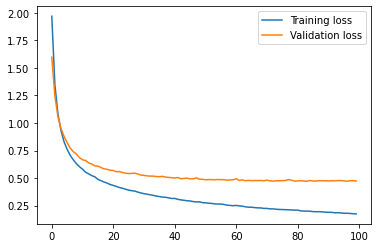

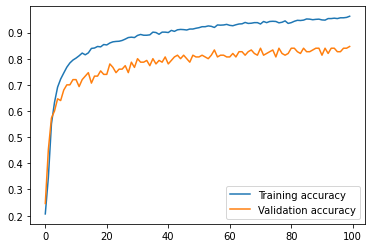

In [ ]:
basemodel_simple = Sequential()
basemodel_simple.add(Dense(4, activation = 'softmax'))

basemodel_simple.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

results=basemodel_simple.fit(carac_train, y_train,
          batch_size=128,
          epochs=100,
          verbose=1,
          validation_split=0.1)


# evaluamos la red en el conjunto de test
score = basemodel_simple.evaluate(carac_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

mostrarEvolucion(results)

# Densenet mejorado

En esta ocasión hemos decidido eliminar de DenseNet la capa de GlobalAveragePooling para trabajar con el tensor de 7x7x1024 mediante una serie de modulos convolucionales.

In [ ]:
from keras.models import Model
from keras.layers import Dense
import keras
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD

def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

opt=SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
datagen_train = ImageDataGenerator(preprocessing_function = preprocess_input)
datagen_test = ImageDataGenerator(preprocessing_function = preprocess_input)

base_model = DenseNet121(weights='imagenet', include_top=False,input_shape=(224,224,3))

#obtener la clasificación mediante densenet con imagenet

carac_train  = base_model.predict(datagen_train.flow(X_train,batch_size = 1,shuffle = False),
                                    verbose = 1,
                                    steps = len(X_train))
carac_test = base_model.predict(datagen_test.flow(X_test,batch_size = 1,shuffle = False),
                                    verbose = 1,
                                    steps = len(X_test))

500/500 [==============================] - 12s 23ms/step


Epoch 1/50
11/11 [==============================] - 5s 231ms/step - loss: 1.6892 - accuracy: 0.5032 - val_loss: 1.6286 - val_accuracy: 0.4667
Epoch 2/50
11/11 [==============================] - 1s 71ms/step - loss: 0.4756 - accuracy: 0.8432 - val_loss: 1.8011 - val_accuracy: 0.5133
Epoch 3/50
11/11 [==============================] - 1s 78ms/step - loss: 0.3886 - accuracy: 0.8650 - val_loss: 1.3870 - val_accuracy: 0.5867
Epoch 4/50
11/11 [==============================] - 1s 71ms/step - loss: 0.3026 - accuracy: 0.8849 - val_loss: 1.1017 - val_accuracy: 0.6400
Epoch 5/50
11/11 [==============================] - 1s 72ms/step - loss: 0.2082 - accuracy: 0.9307 - val_loss: 0.9639 - val_accuracy: 0.7067
Epoch 6/50
11/11 [==============================] - 1s 72ms/step - loss: 0.1341 - accuracy: 0.9560 - val_loss: 0.9138 - val_accuracy: 0.8000
Epoch 7/50
11/11 [==============================] - 1s 77ms/step - loss: 0.1148 - accuracy: 0.9610 - val_loss: 0.6149 - val_accuracy: 0.8200
Epoch 8/50
1

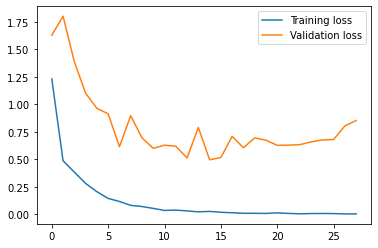

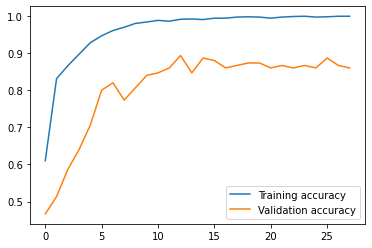

In [ ]:
from keras.callbacks import EarlyStopping

basemodel_simple = Sequential()
basemodel_simple.add(Conv2D(512, kernel_size=(3, 3)))
basemodel_simple.add(BatchNormalization())
basemodel_simple.add(Activation('relu'))
basemodel_simple.add(Conv2D(1024, kernel_size=(3, 3)))
basemodel_simple.add(BatchNormalization())
basemodel_simple.add(Activation('relu'))
basemodel_simple.add(MaxPooling2D((2,2)))
basemodel_simple.add(Dropout(0.5))
basemodel_simple.add(Flatten())
basemodel_simple.add(Dense(200, activation = 'relu'))
basemodel_simple.add(Dropout(0.5))
basemodel_simple.add(Dense(4, activation = 'softmax'))

early_stopping_loss = EarlyStopping(monitor = 'val_loss',
                                        patience = 15,
                                        restore_best_weights = True)
early_stopping_val = EarlyStopping(monitor = "val_accuracy",
                                       patience = 15,
                                       restore_best_weights = True)

basemodel_simple.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

results=basemodel_simple.fit(carac_train, y_train,
          batch_size=128,
          epochs=50,
          verbose=1,
          validation_split=0.1,callbacks=[early_stopping_loss,early_stopping_val])


# evaluamos la red en el conjunto de test
score = basemodel_simple.evaluate(carac_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

mostrarEvolucion(results)

# DenseNet + Inception v3

A continuación, hemos diseñado un modelo en el que hacemos uso de un módulo inception después de usar DenseNet. Para el desarrollo del módulo inception nos hemos ayudado de dos fuentes: [ImplementesMajorArquitecture](https://machinelearningmastery.com/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/) y [Inception-v4 article](https://arxiv.org/abs/1602.07261)

In [ ]:
from keras.models import Model
from keras.layers import Dense
import keras
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD

def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

datagen_train = ImageDataGenerator(preprocessing_function = preprocess_input)
datagen_test = ImageDataGenerator(preprocessing_function = preprocess_input)

base_model = DenseNet121(weights='imagenet', include_top=False,input_shape=(224,224,3))

#obtener la clasificación mediante densenet con imagenet

carac_train  = base_model.predict(datagen_train.flow(X_train,batch_size = 1,shuffle = False),
                                    verbose = 1,
                                    steps = len(X_train))
carac_test = base_model.predict(datagen_test.flow(X_test,batch_size = 1,shuffle = False),
                                    verbose = 1,
                                    steps = len(X_test))

500/500 [==============================] - 12s 24ms/step


Epoch 1/100
43/43 [==============================] - 3s 35ms/step - loss: 1.6018 - accuracy: 0.3612 - val_loss: 0.9262 - val_accuracy: 0.6000
Epoch 2/100
43/43 [==============================] - 1s 25ms/step - loss: 0.8838 - accuracy: 0.6540 - val_loss: 0.7441 - val_accuracy: 0.7000
Epoch 3/100
43/43 [==============================] - 1s 25ms/step - loss: 0.7729 - accuracy: 0.6974 - val_loss: 0.6577 - val_accuracy: 0.7200
Epoch 4/100
43/43 [==============================] - 1s 25ms/step - loss: 0.6680 - accuracy: 0.7489 - val_loss: 0.6092 - val_accuracy: 0.7400
Epoch 5/100
43/43 [==============================] - 1s 25ms/step - loss: 0.6261 - accuracy: 0.7680 - val_loss: 0.6045 - val_accuracy: 0.7400
Epoch 6/100
43/43 [==============================] - 1s 25ms/step - loss: 0.5958 - accuracy: 0.7752 - val_loss: 0.5552 - val_accuracy: 0.7333
Epoch 7/100
43/43 [==============================] - 1s 25ms/step - loss: 0.5219 - accuracy: 0.8143 - val_loss: 0.5416 - val_accuracy: 0.7667
Epoch 

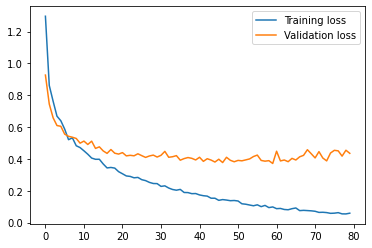

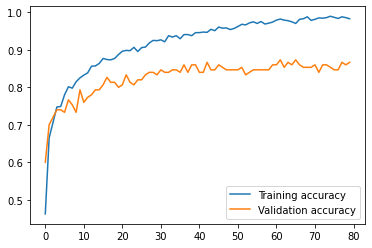

In [ ]:
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.layers import Input, concatenate, GlobalAveragePooling2D

def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out, layer_connect , bool):
	# 1x1 conv
  conv1 = Conv2D(f1, (1,1), padding='same', activation=None)(layer_in)
  conv1 = BatchNormalization()(conv1)
  conv1 = Activation('relu')(conv1)
	# 3x3 conv
  conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
  conv3 = Conv2D(f2_out, (3,3), padding='same', activation=None)(conv3)
  conv3 = BatchNormalization()(conv3)
  conv3 = Activation('relu')(conv3)
	# 5x5 conv
  conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
  conv5 = Conv2D(f3_out, (5,5), padding='same', activation=None)(conv5)
  conv5 = BatchNormalization()(conv5)
  conv5 = Activation('relu')(conv5)
	# 3x3 max pooling
  pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
  pool = Conv2D(f4_out, (1,1), padding='same', activation=None)(pool)
  pool = BatchNormalization()(pool)
  pool = Activation('relu')(pool)
	# concatenate filters, assumes filters/channels last
  if bool : layer_out = concatenate([conv1, conv3, conv5, pool, layer_connect], axis=-1)
  else : layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
 
  return layer_out


visible = Input(shape=(7, 7, 1024))
# add inception block 1
layer = inception_module(visible, 64, 96, 128, 16, 32, 32, visible, True)
# add inception block 1
layer = inception_module(layer, 128, 128, 192, 32, 96, 64, visible, False)
dropout = Dropout(0.25) (layer)
flatten = GlobalAveragePooling2D() (dropout)
dense=  Dense(200,"relu")(flatten)
dropout = Dropout(0.5) (dense)
dense= Dense(4,"softmax")(dropout)
# create model
model = Model(inputs=visible, outputs=dense)



early_stopping_loss = EarlyStopping(monitor = 'val_loss',
                                        patience = 20,
                                        restore_best_weights = True)
early_stopping_val = EarlyStopping(monitor = "val_accuracy",
                                       patience = 20,
                                       restore_best_weights = True)

opt=SGD(lr = 0.001, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

results=model.fit(carac_train, y_train,
          batch_size=32,
          epochs=100,
          verbose=1,
          validation_split=0.1,callbacks=[early_stopping_loss,early_stopping_val])


# evaluamos la red en el conjunto de test
score = model.evaluate(carac_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

mostrarEvolucion(results)

# FT DenseNet

Ante los resultados anteriores, decidimos reentrenar la red eliminando la última capa y añadiendo una capa dense de 4.

In [ ]:
from keras.models import Model
from keras.layers import Dense
import keras
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping

from keras.optimizers import Adam, SGD

def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

opt=SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
datagen_train = ImageDataGenerator(preprocessing_function = preprocess_input, validation_split=0.1)
datagen_test = ImageDataGenerator(preprocessing_function = preprocess_input)

base_model = DenseNet121(weights='imagenet', include_top=False,input_shape=(224,224,3), pooling='avg')


output = Dense(4, activation = 'softmax') (base_model.output)
base_model_FT = Model(inputs = base_model.input, outputs = output)

# Compilación y entrenamiento del modelo.

early_stopping_loss = EarlyStopping(monitor = 'val_loss',
                                        patience = 10,
                                        restore_best_weights = True)
early_stopping_val = EarlyStopping(monitor = "val_accuracy",
                                       patience = 10,
                                       restore_best_weights = True)

base_model_FT.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

hist = base_model_FT.fit(datagen_train.flow(X_train, y_train,batch_size= 16, subset = 'training'),
                    steps_per_epoch= len(X_train)*0.9/16,epochs = 30,
                    validation_data= datagen_train.flow(X_train, y_train,batch_size= 16, subset = 'validation'),
                    validation_steps= len(X_train)*0.1/16,callbacks=[early_stopping_loss,early_stopping_val])

Epoch 1/30
84/84 [==============================] - 34s 214ms/step - loss: 1.0973 - accuracy: 0.6408 - val_loss: 14.4770 - val_accuracy: 0.2867
Epoch 2/30
84/84 [==============================] - 15s 180ms/step - loss: 0.5623 - accuracy: 0.8332 - val_loss: 11.5483 - val_accuracy: 0.4000
Epoch 3/30
84/84 [==============================] - 15s 183ms/step - loss: 0.3679 - accuracy: 0.8849 - val_loss: 0.5412 - val_accuracy: 0.8600
Epoch 4/30
84/84 [==============================] - 16s 185ms/step - loss: 0.2991 - accuracy: 0.9070 - val_loss: 1.1564 - val_accuracy: 0.6800
Epoch 5/30
84/84 [==============================] - 16s 185ms/step - loss: 0.3296 - accuracy: 0.9046 - val_loss: 0.7847 - val_accuracy: 0.8267
Epoch 6/30
84/84 [==============================] - 15s 183ms/step - loss: 0.1363 - accuracy: 0.9577 - val_loss: 0.4466 - val_accuracy: 0.8733
Epoch 7/30
84/84 [==============================] - 16s 184ms/step - loss: 0.1309 - accuracy: 0.9620 - val_loss: 0.2930 - val_accuracy: 0.90

Test loss: 0.3512308895587921
Test accuracy: 0.9120000004768372


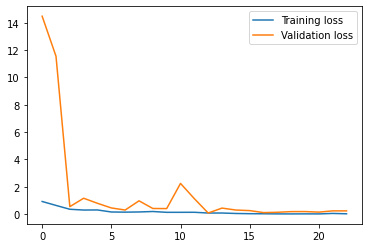

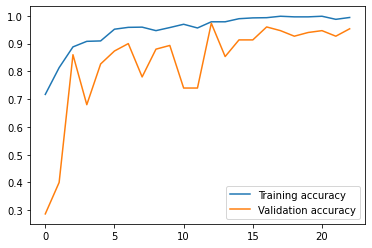

In [ ]:
# evaluamos la red en el conjunto de test
score = base_model_FT.evaluate(datagen_test.flow(X_test,
                                                  y_test,
                                                  batch_size = 1,
                                                  shuffle = False),
                                      verbose = 0,
                                      steps = len(X_test))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

mostrarEvolucion(hist)

# FT con densenet y inception module

Finalmente, decidimos generar una arquitectura mixta entre DenseNet121 y el módulo inception implementado por nosotros para reentrenar la red, obteniendo unos resultados muy prometedores.

Epoch 1/15
84/84 [==============================] - 27s 212ms/step - loss: 1.2971 - accuracy: 0.5018 - val_loss: 0.8059 - val_accuracy: 0.6933
Epoch 2/15
84/84 [==============================] - 16s 189ms/step - loss: 0.4839 - accuracy: 0.8118 - val_loss: 0.4461 - val_accuracy: 0.8333
Epoch 3/15
84/84 [==============================] - 16s 190ms/step - loss: 0.2752 - accuracy: 0.9087 - val_loss: 0.3485 - val_accuracy: 0.8533
Epoch 4/15
84/84 [==============================] - 16s 188ms/step - loss: 0.2046 - accuracy: 0.9267 - val_loss: 0.3096 - val_accuracy: 0.9067
Epoch 5/15
84/84 [==============================] - 16s 187ms/step - loss: 0.1360 - accuracy: 0.9543 - val_loss: 0.2512 - val_accuracy: 0.9267
Epoch 6/15
84/84 [==============================] - 16s 186ms/step - loss: 0.0963 - accuracy: 0.9724 - val_loss: 0.2655 - val_accuracy: 0.9200
Epoch 7/15
84/84 [==============================] - 16s 188ms/step - loss: 0.0959 - accuracy: 0.9675 - val_loss: 0.2078 - val_accuracy: 0.9467

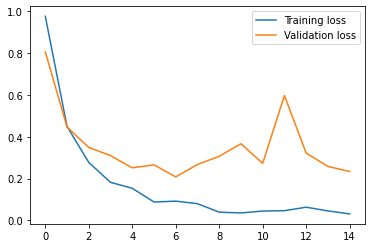

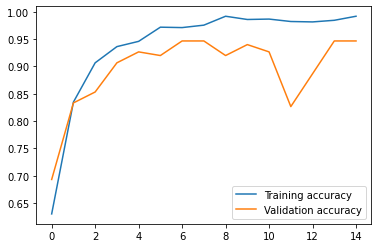

In [ ]:
from keras.models import Model
from keras.layers import Dense
import keras
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D, concatenate, GlobalAveragePooling2D

from keras.optimizers import Adam, SGD

def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out, layer_connect , bool):
	# 1x1 conv
  conv1 = Conv2D(f1, (1,1), padding='same', activation=None)(layer_in)
  conv1 = BatchNormalization()(conv1)
  conv1 = Activation('relu')(conv1)
	# 3x3 conv
  conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
  conv3 = Conv2D(f2_out, (3,3), padding='same', activation=None)(conv3)
  conv3 = BatchNormalization()(conv3)
  conv3 = Activation('relu')(conv3)
	# 5x5 conv
  conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
  conv5 = Conv2D(f3_out, (5,5), padding='same', activation=None)(conv5)
  conv5 = BatchNormalization()(conv5)
  conv5 = Activation('relu')(conv5)
	# 3x3 max pooling
  pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
  pool = Conv2D(f4_out, (1,1), padding='same', activation=None)(pool)
  pool = BatchNormalization()(pool)
  pool = Activation('relu')(pool)
	# concatenate filters, assumes filters/channels last
  if bool : layer_out = concatenate([conv1, conv3, conv5, pool, layer_connect], axis=-1)
  else : layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
 
  return layer_out


opt=SGD(lr = 0.001, decay = 1e-6, momentum = 0.9, nesterov = True)
datagen_train = ImageDataGenerator(preprocessing_function = preprocess_input, validation_split=0.1)
datagen_test = ImageDataGenerator(preprocessing_function = preprocess_input)

base_model = DenseNet121(weights='imagenet', include_top=False,input_shape=(224,224,3))

# add inception block 1
layer = inception_module(base_model.output, 64, 96, 128, 16, 32, 32, base_model.output, True)
flatten = GlobalAveragePooling2D() (layer)
dropout = Dropout(0.25) (flatten)
dense=  Dense(200,"relu")(dropout)
dropout = Dropout(0.5) (dense)
dense= Dense(4,"softmax")(dropout)

base_model_FT = Model(inputs = base_model.input, outputs = dense)

# Compilación y entrenamiento del modelo.

base_model_FT.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

hist = base_model_FT.fit(datagen_train.flow(X_train, y_train,batch_size= 16, subset = 'training'),
                    steps_per_epoch= len(X_train)*0.9/16,epochs = 15,
                    validation_data= datagen_train.flow(X_train, y_train,batch_size= 16, subset = 'validation'),
                    validation_steps= len(X_train)*0.1/16)

# evaluamos la red en el conjunto de test
score = base_model_FT.evaluate(datagen_test.flow(X_test,
                                                  y_test,
                                                  batch_size = 1,
                                                  shuffle = False),
                                      verbose = 0,
                                      steps = len(X_test))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

mostrarEvolucion(hist)

# Fotos Inception

Aqui generamos las fotos de las dos arquitecturas de los módulos inception creados para la memoria.

## densenet + inception v3

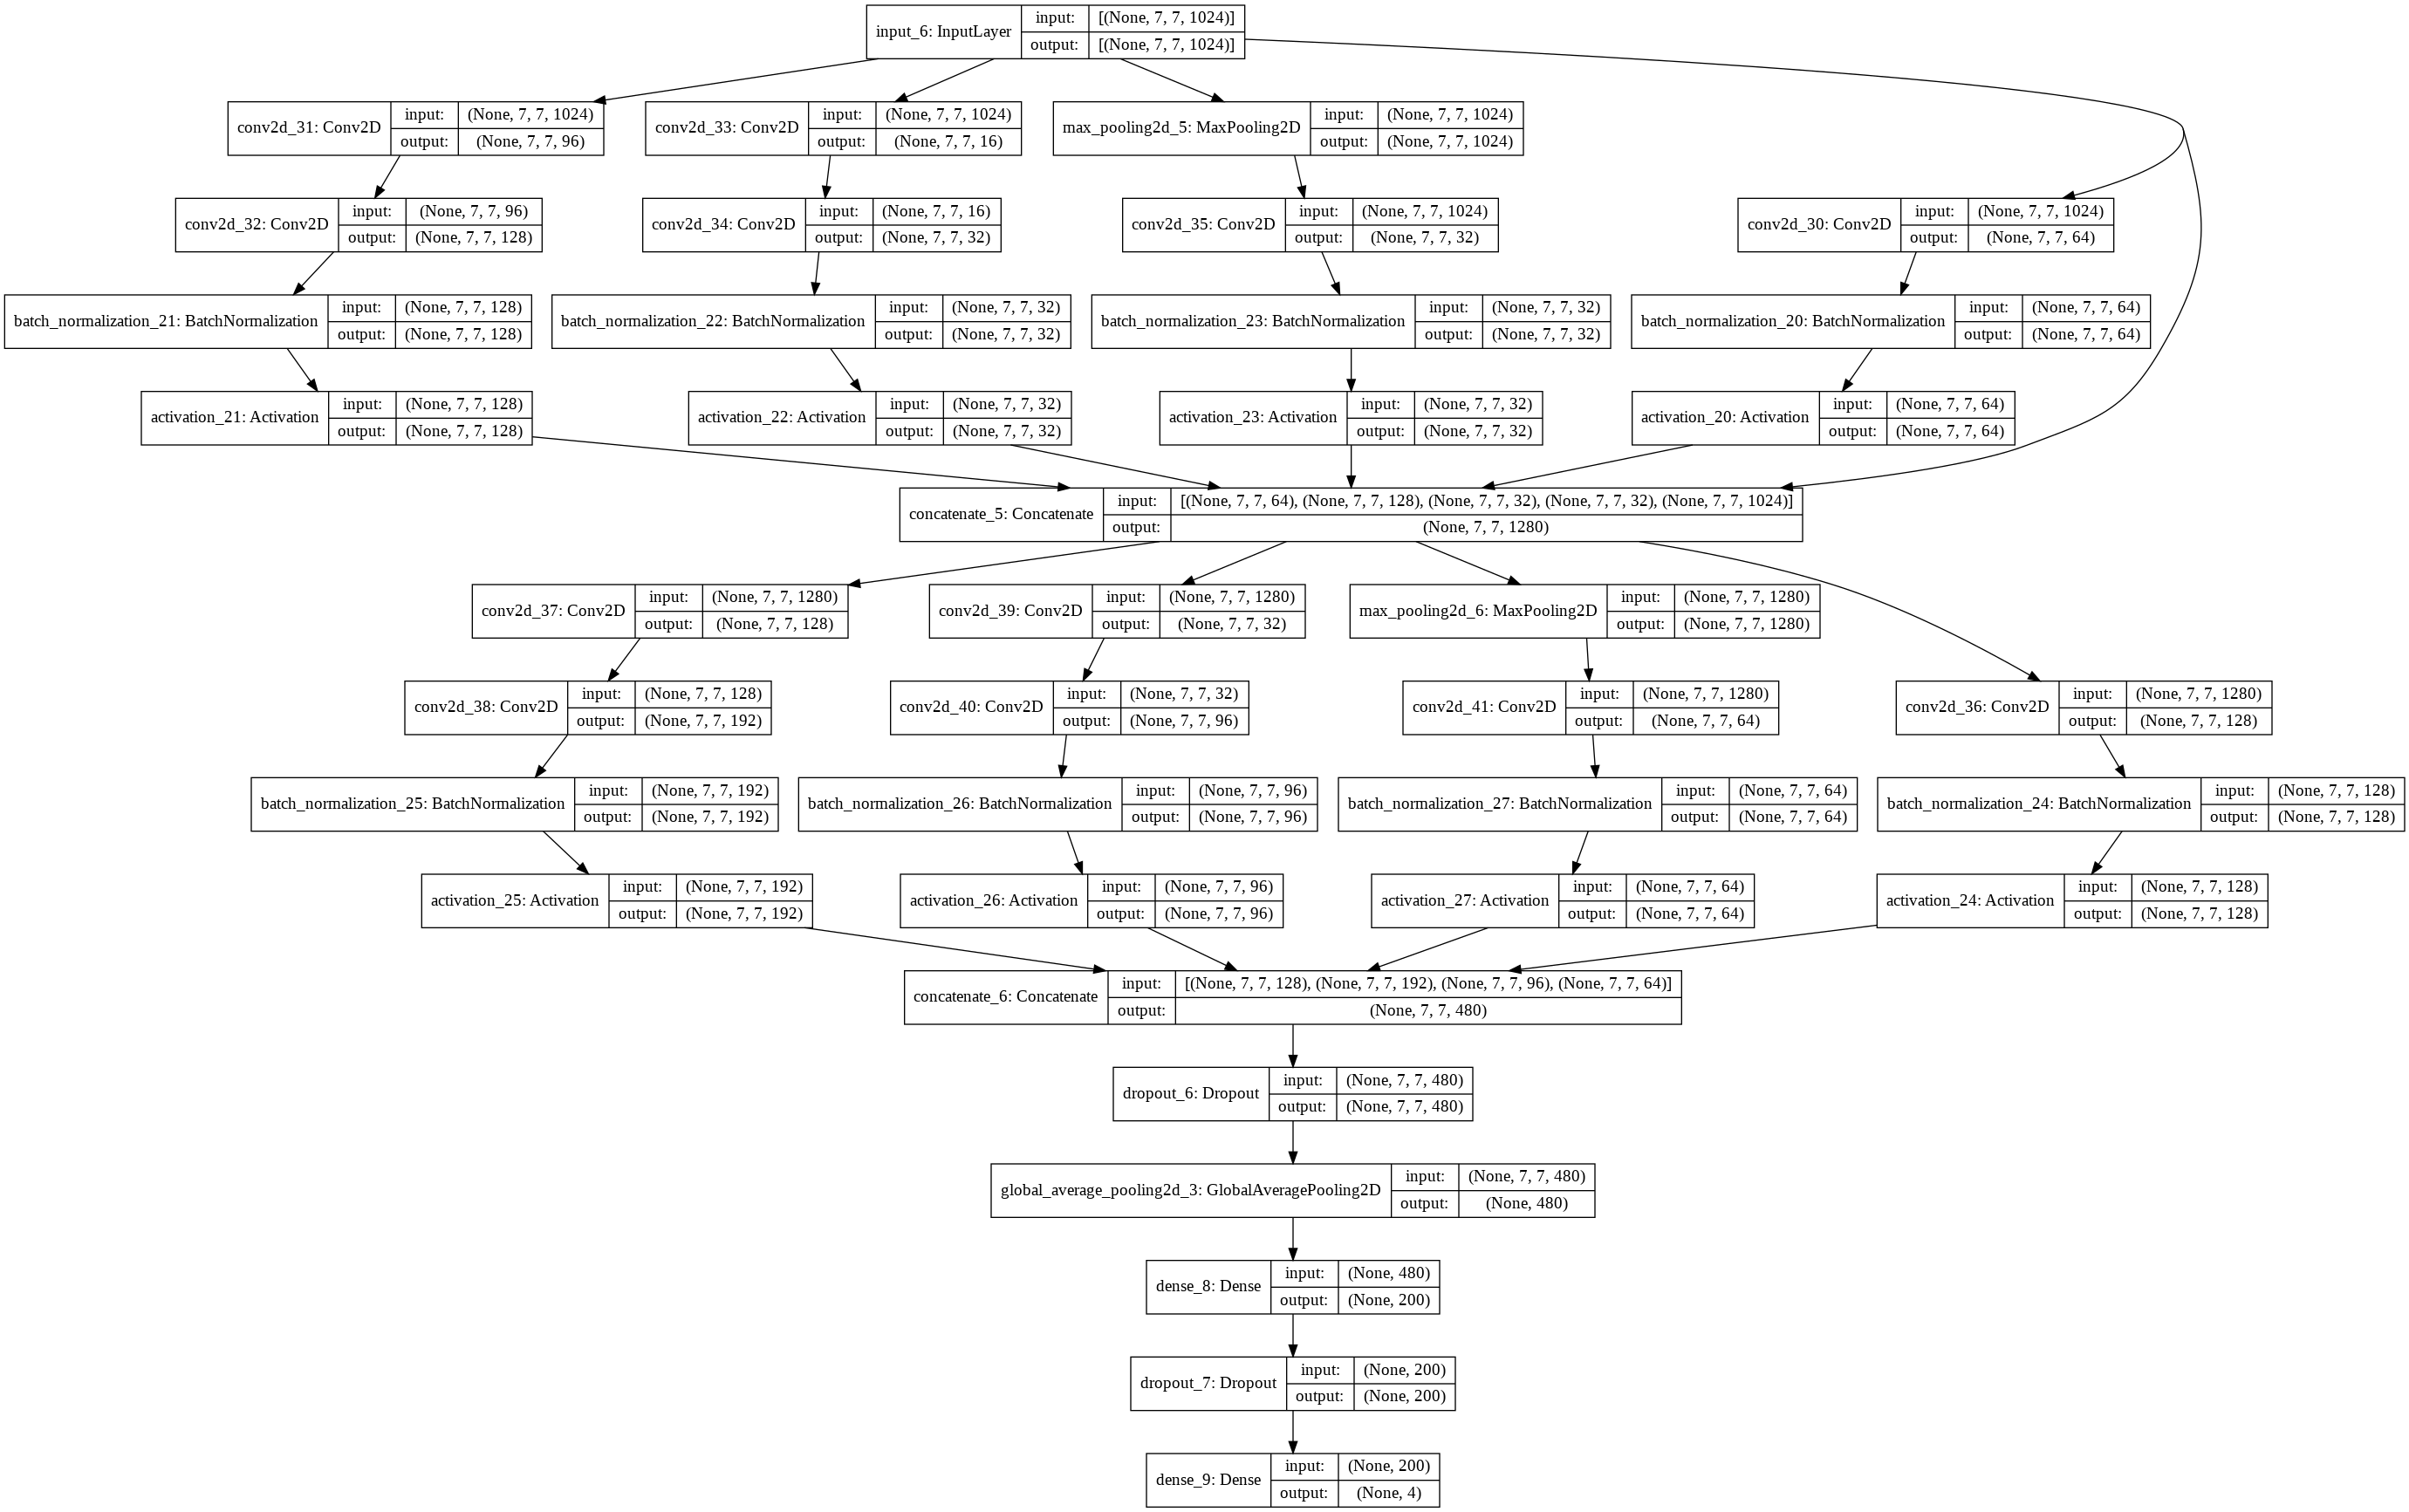

In [ ]:
# example of creating a CNN with an inception module
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers.merge import concatenate
from keras.utils import plot_model

def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out, layer_connect , bool):
	# 1x1 conv
  conv1 = Conv2D(f1, (1,1), padding='same', activation=None)(layer_in)
  conv1 = BatchNormalization()(conv1)
  conv1 = Activation('relu')(conv1)
	# 3x3 conv
  conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
  conv3 = Conv2D(f2_out, (3,3), padding='same', activation=None)(conv3)
  conv3 = BatchNormalization()(conv3)
  conv3 = Activation('relu')(conv3)
	# 5x5 conv
  conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
  conv5 = Conv2D(f3_out, (5,5), padding='same', activation=None)(conv5)
  conv5 = BatchNormalization()(conv5)
  conv5 = Activation('relu')(conv5)
	# 3x3 max pooling
  pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
  pool = Conv2D(f4_out, (1,1), padding='same', activation=None)(pool)
  pool = BatchNormalization()(pool)
  pool = Activation('relu')(pool)
	# concatenate filters, assumes filters/channels last
  if bool : layer_out = concatenate([conv1, conv3, conv5, pool, layer_connect], axis=-1)
  else : layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
 
  return layer_out


visible = Input(shape=(7, 7, 1024))
# add inception block 1
layer = inception_module(visible, 64, 96, 128, 16, 32, 32, visible, True)
# add inception block 1
layer = inception_module(layer, 128, 128, 192, 32, 96, 64, visible, False)
dropout = Dropout(0.25) (layer)
flatten = GlobalAveragePooling2D() (dropout)
dense=  Dense(200,"relu")(flatten)
dropout = Dropout(0.5) (dense)
dense= Dense(4,"softmax")(dropout)
# create model
model = Model(inputs=visible, outputs=dense)

plot_model(model, show_shapes=True, to_file='multiple_vgg_blocks.png')

## Densenet + inception v3 FT

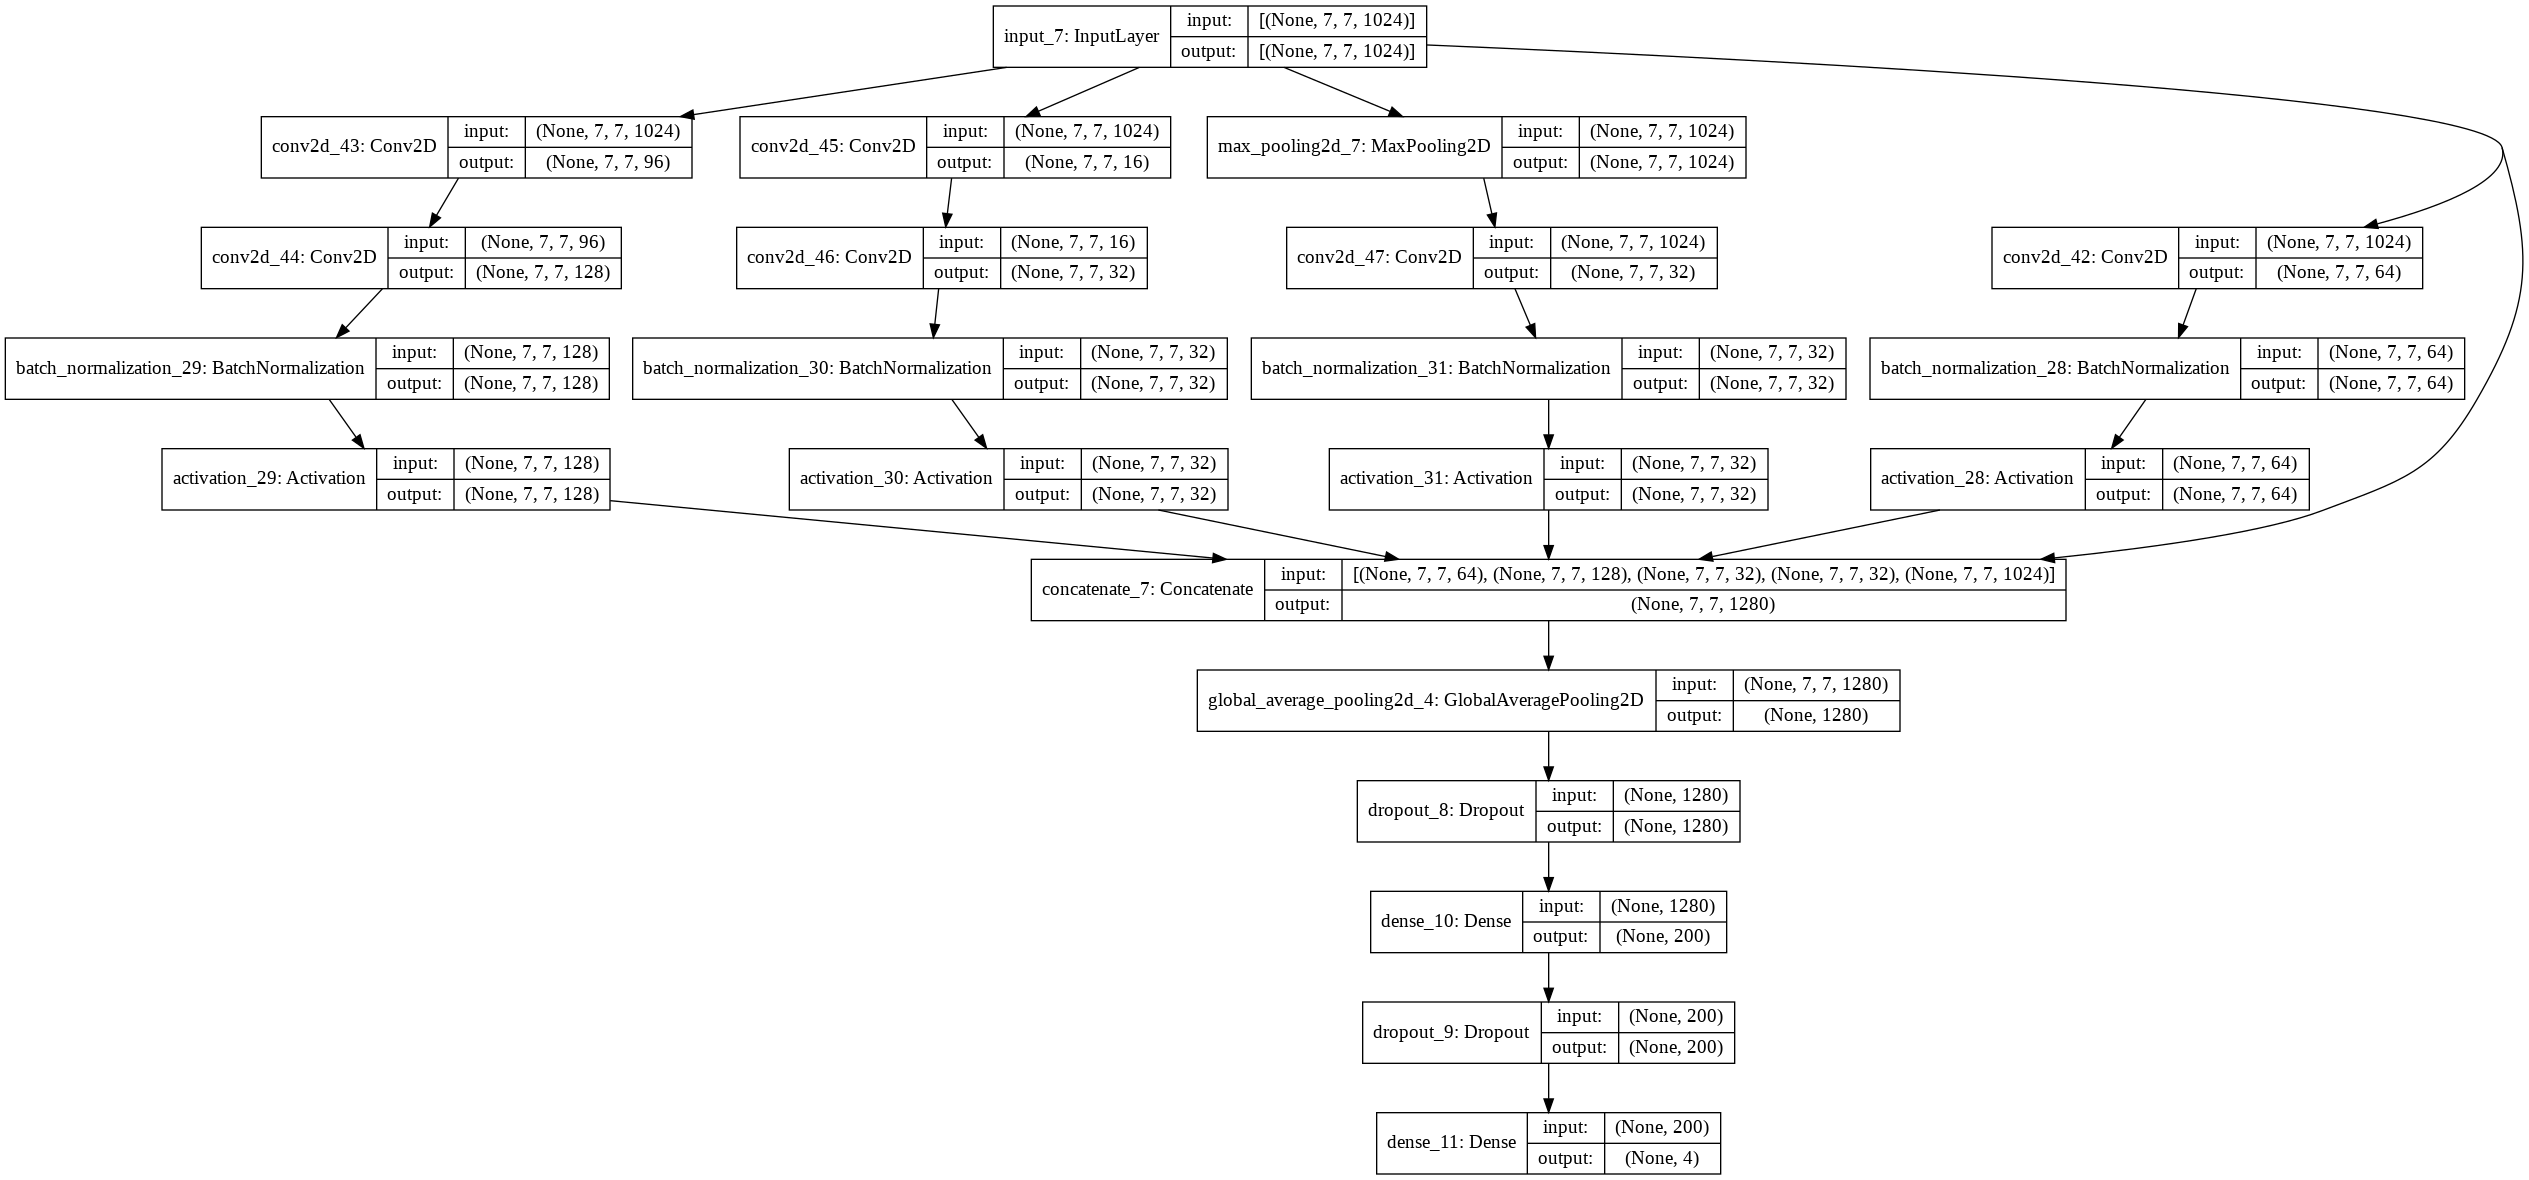

In [ ]:
# example of creating a CNN with an inception module
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers.merge import concatenate
from keras.utils import plot_model

def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out, layer_connect , bool):
	# 1x1 conv
  conv1 = Conv2D(f1, (1,1), padding='same', activation=None)(layer_in)
  conv1 = BatchNormalization()(conv1)
  conv1 = Activation('relu')(conv1)
	# 3x3 conv
  conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
  conv3 = Conv2D(f2_out, (3,3), padding='same', activation=None)(conv3)
  conv3 = BatchNormalization()(conv3)
  conv3 = Activation('relu')(conv3)
	# 5x5 conv
  conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
  conv5 = Conv2D(f3_out, (5,5), padding='same', activation=None)(conv5)
  conv5 = BatchNormalization()(conv5)
  conv5 = Activation('relu')(conv5)
	# 3x3 max pooling
  pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
  pool = Conv2D(f4_out, (1,1), padding='same', activation=None)(pool)
  pool = BatchNormalization()(pool)
  pool = Activation('relu')(pool)
	# concatenate filters, assumes filters/channels last
  if bool : layer_out = concatenate([conv1, conv3, conv5, pool, layer_connect], axis=-1)
  else : layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
 
  return layer_out


visible = Input(shape=(7, 7, 1024))
# add inception block 1
layer = inception_module(visible, 64, 96, 128, 16, 32, 32, visible, True)
flatten = GlobalAveragePooling2D() (layer)
dropout = Dropout(0.25) (flatten)
dense=  Dense(200,"relu")(dropout)
dropout = Dropout(0.5) (dense)
dense= Dense(4,"softmax")(dropout)
# create model
model = Model(inputs=visible, outputs=dense)

plot_model(model, show_shapes=True, to_file='multiple_vgg_blocks.png')

# Predicción

vamos a coger una imagen del conjunto de test para probar la predicción

In [ ]:
y_test[297]

array([0, 0, 0, 1])

In [ ]:
X_pred=np.array([X_test[297]])

carac_pred = base_model_FT.predict(datagen_test.flow(X_pred,batch_size = 1,shuffle = False),
                                    verbose = 1,
                                    steps = len(X_pred))

1/1 [==============================] - 0s 41ms/step


In [ ]:
carac_pred

array([[7.0887171e-07, 4.0340669e-07, 1.4536325e-06, 9.9999750e-01]],
      dtype=float32)

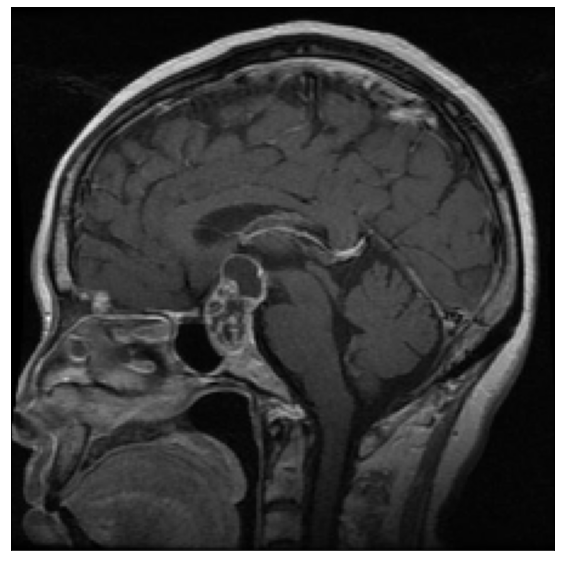

In [ ]:
print_im(X_pred[0])